In [44]:
import numpy as np
import os
import tensorflow as tf
import urllib2
import sys
import matplotlib.pyplot as plt
import cervix
import sklearn.metrics as sm

sys.path.append('/home/jt2/Workspace/models/slim')
from datasets import dataset_utils
from nets import inception
from preprocessing import inception_preprocessing
import image_processing
%matplotlib inline

In [2]:
url = "http://download.tensorflow.org/models/inception_v1_2016_08_28.tar.gz"
checkpoints_dir = '/tmp/checkpoints'

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

# dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

slim = tf.contrib.slim
image_size = inception.inception_v1.default_image_size

In [6]:
from preprocessing import inception_preprocessing
import tensorflow as tf

slim = tf.contrib.slim


def load_batch(dataset, batch_size=32, height=299, width=299, is_training=False, shuffle=True):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32,
        common_queue_min=8, shuffle=shuffle)
    image_raw, label, label_text, filename = data_provider.get(['image', 'label', 'label_text', 'filename'])

    
    # Preprocess image for usage by Inception.
    image = inception_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels, labels_text, filenames = tf.train.batch(
          [image, image_raw, label, label_text, filename],
          batch_size=batch_size,
          num_threads=1,
          capacity=2 * batch_size)
    
    return images, images_raw, labels, labels_text, filenames

In [4]:
# FLAGS = tf.app.flags.FLAGS
# FLAGS.data_dir = '/home/jt2/Workspace/cervix/train'
# FLAGS.train_dir= '/home/jt2/Workspace/cervix/train'
# FLAGS.batch_size = 32
# FLAGS.num_readers = 4
# FLAGS.num_preprocess_threads = 4
# FLAGS.input_queue_memory_factor = 1
# FLAGS.image_size = 224

In [3]:
# cervix_data_dir = '/home/jt2/Workspace/cervix/train/'
# train_dir = '/tmp/inception_finetuned/'
cervix_data_dir = '/home/jt2/Workspace/cervix/30_img/'
train_dir = '/tmp/inception_finetuned/30_img'

In [5]:
def get_init_fn():
    """Returns a function run by the chief worker to warm-start the training."""
    checkpoint_exclude_scopes=["InceptionV1/Logits", "InceptionV1/AuxLogits"]
    
    exclusions = [scope.strip() for scope in checkpoint_exclude_scopes]

    variables_to_restore = []
    for var in slim.get_model_variables():
        excluded = False
        for exclusion in exclusions:
            if var.op.name.startswith(exclusion):
                excluded = True
                break
        if not excluded:
            variables_to_restore.append(var)
#     variables_to_restore = slim.get_variables_to_restore(exclude=exclusions)
    
    for i in variables_to_restore:
        print i.name

    return slim.assign_from_checkpoint_fn(
      os.path.join(checkpoints_dir, 'inception_v1.ckpt'),
      variables_to_restore)

In [6]:
# init train
with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = cervix.get_split('train', cervix_data_dir)
    images, _, labels = load_batch(dataset, height=image_size, width=image_size)
    
#     Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(images, num_classes=dataset.num_classes, is_training=True)
        
    labels = tf.subtract(labels, 1)
    
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    one_hot_labels = tf.cast(one_hot_labels, tf.int64)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()

    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/Total Loss', total_loss)
  
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    train_op = slim.learning.create_train_op(total_loss, optimizer)
    
    # Run the training:
    final_loss = slim.learning.train(
        train_op,
        logdir=train_dir,
        init_fn=get_init_fn(),
        number_of_steps=33)
        
  
print('Finished training. Last batch loss %f' % final_loss)

Instructions for updating:
Use tf.losses.softmax_cross_entropy instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Summary name losses/Total Loss is illegal; using losses/Total_Loss instead.
InceptionV1/Conv2d_1a_7x7/weights:0
InceptionV1/Conv2d_1a_7x7/BatchNorm/beta:0
InceptionV1/Conv2d_1a_7x7/BatchNorm/moving_mean:0
InceptionV1/Conv2d_1a_7x7/BatchNorm/moving_variance:0
InceptionV1/Conv2d_2b_1x1/weights:0
InceptionV1/Conv2d_2b_1x1/BatchNorm/beta:0
InceptionV1/Conv2d_2b_1x1/BatchNorm/moving_mean:0
InceptionV1/Conv2d_2b_1x1/BatchNorm/moving_variance:0
InceptionV1/Conv2d_2c_3x3/weights:0
InceptionV1/Conv2d_2c_3x3/BatchNorm/beta:0
InceptionV1/Conv2d_2c_3x3/BatchNorm/moving_mean:0
Inceptio

In [24]:
# train from checkpoint
with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = cervix.get_split('train', cervix_data_dir)
    images, _, labels, _,_ = load_batch(dataset, height=image_size, width=image_size)
    
#     Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(images, num_classes=dataset.num_classes, is_training=True)
        
    labels = tf.subtract(labels, 1)
    
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()

    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/Total Loss', total_loss)
  
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    train_op = slim.learning.create_train_op(total_loss, optimizer)
    
    # Run the training:
    final_loss = slim.learning.train(
        train_op,
        logdir=train_dir,
        number_of_steps=200)
        
  
print('Finished training. Last batch loss %f' % final_loss)

Instructions for updating:
Use tf.losses.softmax_cross_entropy instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Summary name losses/Total Loss is illegal; using losses/Total_Loss instead.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global step 93: loss = 0.1808 (24.51 sec/step)
INFO:tensorflow:global step 94: loss = 0.1807 (10.06 sec/step)
INFO:tensorflow:global step 95: loss = 0.1806 (9.77 sec/step)
INFO:tensorflow:global step 96: loss = 0.1805 (10.26 sec/step)
INFO:tensorflow:global step 97: loss = 0.1804 (9.88 sec/step)
INFO:tensorflow:global step 98: loss = 0.1804 (9.51 sec/step)
INFO:tensorflow:global ste

Instructions for updating:
Use `tf.local_variables_initializer` instead.
[[ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1

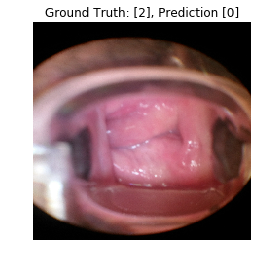

             precision    recall  f1-score   support

          0       0.16      0.25      0.19        48
          1       0.62      0.08      0.15       180
          2       0.25      0.69      0.37        72

avg / total       0.46      0.26      0.21       300



In [31]:
#EVALUATE TRAINED MODEL

import numpy as np
import tensorflow as tf
from nets import inception

slim = tf.contrib.slim

image_size = inception.inception_v1.default_image_size
batch_size = 1

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
#     dataset = cervix.get_split('train', cervix_data_dir)
    dataset = cervix.get_split('train', '/home/jt2/Workspace/cervix/train')
#     images, images_raw, labels = load_batch(dataset, height=image_size, width=image_size, is_training=False)
    images, images_raw, labels, labels_name, filenames = load_batch(dataset, 
                                                           batch_size=300, 
                                                           shuffle=False, 
                                                           height=image_size, 
                                                           width=image_size, 
                                                           is_training=True)
    
    labels = tf.subtract(labels, 1)
    
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(images, num_classes=dataset.num_classes, is_training=False)

    probabilities = tf.nn.softmax(logits)
    
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    init_fn = slim.assign_from_checkpoint_fn(
      checkpoint_path,
      slim.get_variables_to_restore())
    
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.initialize_local_variables())
            init_fn(sess)
#             np_probabilities, np_images_raw, np_labels = sess.run([probabilities, images_raw, labels])
            np_probabilities, np_images_raw, np_labels, np_images, logit_train, one_hot, label_name, filename = sess.run([probabilities, images_raw, labels, images, logits, one_hot_labels, labels_name, filenames])
    
            for i in xrange(batch_size): 
                image = np_images_raw[i, :, :, :]
                image_train = np_images[i, :, :, :]
                true_label = np_labels[i]
                predicted_label = np.argmax(np_probabilities[i, :])
                print one_hot
                print logit_train
                print np_probabilities
                print np.argmax(np_probabilities, axis=1)
                print np_labels
                print "label_name"
                print label_name
                print "filename"
                print filename
                
#                 predicted_name = dataset.labels_to_names[predicted_label]
#                 true_name = dataset.labels_to_names[true_label]
                
                plt.figure()
                plt.imshow(image.astype(np.uint8))
#                 plt.title('Ground Truth: [%s], Prediction [%s]' % (true_name, predicted_name))
                plt.title('Ground Truth: [%s], Prediction [%s]' % (true_label, predicted_label))
                plt.axis('off')
                plt.show()
            
            print(sm.classification_report(np_labels, np.argmax(np_probabilities, axis=1)))

In [50]:
from __future__ import division
pred = np.argmax(np_probabilities,axis=1)
is_right = np.equal(np_labels, pred)
log_loss = sm.log_loss(np_labels, np_probabilities)
print "Accuracy: %f" % (np.count_nonzero(is_right)/is_right.shape[0])
print "Log loss: %f" % log_loss

Accuracy: 0.256667
Log loss: 3.506847


In [32]:
index_1 = np.where(np_labels == 0)
index_2 = np.where(np_labels == 1)
index_3 = np.where(np_labels == 2)
df1 = pd.DataFrame(np_probabilities[index_1], index=filename[index_1])
df1 = df1.sort_index()
df2 = pd.DataFrame(np_probabilities[index_2], index=filename[index_2])
df2 = df2.sort_index()
df3 = pd.DataFrame(np_probabilities[index_3], index=filename[index_3])
df3 = df3.sort_index()
print df1
print df2
print df3

                 0         1         2
0.jpg     0.953321  0.000906  0.045773
1019.jpg  0.980592  0.002424  0.016983
102.jpg   0.041243  0.050374  0.908382
1033.jpg  0.000234  0.000808  0.998958
1040.jpg  0.065909  0.044660  0.889431
1070.jpg  0.049961  0.879810  0.070229
1136.jpg  0.427795  0.105267  0.466939
1154.jpg  0.026682  0.005802  0.967516
1179.jpg  0.050437  0.026163  0.923400
12.jpg    0.257274  0.095959  0.646767
1279.jpg  0.004208  0.992334  0.003458
1281.jpg  0.764921  0.131177  0.103902
1285.jpg  0.322213  0.005589  0.672198
1326.jpg  0.975604  0.001430  0.022966
1384.jpg  0.946560  0.029065  0.024375
1422.jpg  0.941172  0.012420  0.046408
1427.jpg  0.033042  0.005036  0.961923
1437.jpg  0.048036  0.017916  0.934049
1468.jpg  0.008730  0.001979  0.989291
171.jpg   0.115124  0.650440  0.234436
181.jpg   0.066626  0.059930  0.873444
191.jpg   0.103510  0.001204  0.895286
237.jpg   0.385801  0.010819  0.603380
252.jpg   0.826041  0.133426  0.040533
254.jpg   0.115167  0.040

In [10]:
import pandas as pd
df = pd.DataFrame(np_probabilities, index=filename)
df

,0,1,2
402.jpg,0.001724,0.003810,0.994466
1005.jpg,0.083030,0.001178,0.915792
900.jpg,0.687203,0.192766,0.120032
301.jpg,0.112723,0.356717,0.530560
600.jpg,0.081325,0.458353,0.460322
404.jpg,0.269435,0.104138,0.626428
800.jpg,0.002376,0.010887,0.986737
1101.jpg,0.000164,0.000122,0.999715
236.jpg,0.057569,0.002234,0.940198
802.jpg,0.040817,0.849566,0.109618


In [ ]:
print image_train.shape
image
f, (ax1, ax2, ax3) = plt.subplots(1, 3,sharey=True)
ax1.imshow(image_train[:,:,0], cmap='gray')
ax2.imshow(image_train[:,:,1], cmap='gray')
ax3.imshow(image_train[:,:,2], cmap='gray')
plt.show()

In [20]:
#CHECK WEIGHTS
import numpy as np
import tensorflow as tf
from nets import inception

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
#     dataset = cervix.get_split('train', cervix_data_dir)
    images, images_raw, labels = load_batch(dataset, shuffle=True, height=image_size, width=image_size, is_training=True)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(images, num_classes=dataset.num_classes, is_training=False)

    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    init_fn = slim.assign_from_checkpoint_fn(
      checkpoint_path,
      slim.get_variables_to_restore())
    
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.initialize_local_variables())
            init_fn(sess)
#             in_logits = slim.get_variables_by_name('InceptionV1/Logits/Conv2d_0c_1x1/weights')
#             stay_same = slim.get_variables_by_name('InceptionV1/Mixed_5c/Branch_3/Conv2d_0b_1x1/weights')
            variables = slim.get_variables()
#             l_out, ss = sess.run([in_logits, stay_same])
            all_var = sess.run(variables)
        
        print "DONE"

Instructions for updating:
Use `tf.local_variables_initializer` instead.
DONE


In [87]:
np.array(all_var[2]).shape

(64,)

In [18]:
print l_outa.shape
l_outa = np.array(l_out)
l_outa[:,:,:,0:10,:].shape
ssa = np.array(ss)
print ssa.shape
print l_outa[:,:,:,0:10,:]
print ssa[:,:,:,0,:]
# for i in variables:
#     print i.name

NameError: name 'l_outa' is not defined

In [66]:
print l_outa.shape
l_outa = np.array(l_out)
l_outa[:,:,:,0:10,:].shape
ssa = np.array(ss)
print ssa.shape
print l_outa[:,:,:,0:10,:]
print ssa[:,:,:,0,:]

(1, 1, 1, 1024, 3)
(1, 1, 1, 832, 128)
[[[[[ 0.0225546  -0.03773157 -0.03563033]
    [ 0.00560903  0.0386457   0.03008164]
    [-0.00972843  0.05667179 -0.03700553]
    [ 0.0324546  -0.0141386   0.02045678]
    [ 0.06317345  0.0256234   0.02454718]
    [ 0.0775746   0.03653196  0.03690426]
    [-0.02463171  0.05951761 -0.04160601]
    [ 0.03234899 -0.00583618 -0.0186235 ]
    [-0.07580843 -0.03416779 -0.01580554]
    [-0.00908197  0.07602486  0.0020398 ]]]]]
[[[[-0.03159119 -0.03172385  0.10651094  0.08326013  0.02682466  0.02241646
    -0.06258097  0.02906412 -0.00209496 -0.10497356  0.02025996 -0.08106352
    -0.01673872 -0.01791217 -0.04079831 -0.05992773 -0.0578336  -0.0627177
    -0.0681162   0.00444865  0.07075203  0.01951352 -0.00307408  0.0244806
     0.03536874  0.03084046  0.0278339   0.02593502  0.01365609 -0.05791332
    -0.03000265  0.07679283  0.06262504 -0.05136951 -0.05276458 -0.00673586
    -0.09805413  0.08242258  0.08185671  0.08718041 -0.05881884 -0.00320945
    -0.

In [21]:
for i in xrange(len(variables)):
    arr = np.array(all_var[i])
    print "%d %-20.20s mean: %10.10s var: %s" % (i, variables[i].name, np.mean(arr), np.var(arr))

0 InceptionV1/Conv2d_1 mean: -0.0009460 var: 0.0400133
1 InceptionV1/Conv2d_1 mean:    1.04861 var: 2.12383
2 InceptionV1/Conv2d_1 mean:  0.0124993 var: 0.0385049
3 InceptionV1/Conv2d_1 mean:    1.58039 var: 2.85051
4 InceptionV1/Conv2d_2 mean: -0.0143133 var: 0.0422265
5 InceptionV1/Conv2d_2 mean:   0.172336 var: 0.469718
6 InceptionV1/Conv2d_2 mean:   -3.13273 var: 17.0639
7 InceptionV1/Conv2d_2 mean:    3.43527 var: 3.6421
8 InceptionV1/Conv2d_2 mean: -0.0022323 var: 0.00466029
9 InceptionV1/Conv2d_2 mean:   0.143461 var: 1.02289
10 InceptionV1/Conv2d_2 mean:  -0.770304 var: 2.96827
11 InceptionV1/Conv2d_2 mean:    1.72872 var: 2.33934
12 InceptionV1/Mixed_3b mean: -0.0008283 var: 0.00862204
13 InceptionV1/Mixed_3b mean:   0.472513 var: 0.571388
14 InceptionV1/Mixed_3b mean:  -0.108891 var: 2.82709
15 InceptionV1/Mixed_3b mean:    1.54839 var: 0.852669
16 InceptionV1/Mixed_3b mean: -0.0046092 var: 0.00647423
17 InceptionV1/Mixed_3b mean:  0.0220699 var: 0.27361
18 InceptionV1/Mixed_

In [20]:
for i in xrange(len(variables)):
    arr = np.array(all_var[i])
    print "%d %-20.20s mean: %10.10s var: %s" % (i, variables[i].name, np.mean(arr), np.var(arr))

0 InceptionV1/Conv2d_1 mean: -0.0064323 var: 0.0435678
1 InceptionV1/Conv2d_1 mean:    1.03797 var: 2.15021
2 InceptionV1/Conv2d_1 mean:  0.0150122 var: 0.0374826
3 InceptionV1/Conv2d_1 mean:    1.66857 var: 2.95727
4 InceptionV1/Conv2d_2 mean: -0.0091337 var: 0.0454506
5 InceptionV1/Conv2d_2 mean:   0.169888 var: 0.491601
6 InceptionV1/Conv2d_2 mean:   -3.13901 var: 17.1257
7 InceptionV1/Conv2d_2 mean:      3.506 var: 3.8374
8 InceptionV1/Conv2d_2 mean: -0.0040001 var: 0.00781292
9 InceptionV1/Conv2d_2 mean:   0.141096 var: 1.04669
10 InceptionV1/Conv2d_2 mean:  -0.771427 var: 2.98116
11 InceptionV1/Conv2d_2 mean:    1.91433 var: 2.41738
12 InceptionV1/Mixed_3b mean: -0.0006131 var: 0.0119102
13 InceptionV1/Mixed_3b mean:   0.465727 var: 0.567721
14 InceptionV1/Mixed_3b mean:  -0.105582 var: 2.8332
15 InceptionV1/Mixed_3b mean:    1.56025 var: 0.867198
16 InceptionV1/Mixed_3b mean: -0.0066324 var: 0.00973598
17 InceptionV1/Mixed_3b mean:  0.0210319 var: 0.270449
18 InceptionV1/Mixed_3